# Music Emotion Recognition
This notebook provides the code for implementing a BERT classiier 

## Importing libraries

In [1]:
# !pip install music21 miditoolkit miditok

In [2]:
# %pip install --user torch==1.7.0 torchvision==0.8.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html

In [3]:
# !pip install transformers

In [1]:
import numpy as np 
import pandas as pd 
from io import open
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
from miditok import get_midi_programs, REMI, MIDILike
from miditoolkit import MidiFile
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig, BertModel

In [2]:
torch.__version__

'1.7.0'

In [3]:
device = 'cuda'

In [4]:
torch.cuda.empty_cache()

In [5]:
torch.cuda.is_available()

True

In [6]:
# Seed
# seed = 22
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Loading the Dataset

In [7]:
# how a midi file looks like
midi = MidiFile('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/midis/Q1__8v0MFBZoco_0.mid')
midi

ticks per beat: 384
max tick: 46051
tempo changes: 1
time sig: 1
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [8]:
# for now, we will only be using for piano right since it determines the melody
midi.instruments

[Instrument(program=0, is_drum=False, name="")]

In [9]:
# file path to the MIDI files
files_paths = list(glob.glob('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/midis/*.mid'))
# reading labels
labels_df = pd.read_csv('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/label.csv')
labels_df = list(labels_df['4Q'])

In [10]:
import muspy

def return_range(music):
    h = 0
    l = 127
    for track in music.tracks:
        for note in track.notes:
            if note.pitch > h:
                h = note.pitch
            if note.pitch < l:
                l = note.pitch
    return [h, l]

tempos = []
pitches = []

for file in files_paths:
    music = muspy.read_midi(file)
    tempos.append(music.tempos[0].qpm)
    pitches.extend(return_range(music))

In [11]:
print("The unique tempos found in the dataset are: ", set(tempos))
print('minimum pitch found', min(pitches))
print('maximum pitch found', max(pitches))

The unique tempos found in the dataset are:  {120.0}
minimum pitch found 22
maximum pitch found 105


In [12]:
pitch_range = range(22, 105)
additional_tokens = {'Chord': True, 'Rest': True, 'Tempo': True, 'Program': False,
                     'rest_range': (2, 4),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (100, 140),
                     'TimeSignature':None}  # (min, max)

In [13]:
# create a list of notes
# this stores the REMI encoded tokens of the midi files

def load_files(files_paths, encoder = REMI(additional_tokens)):
    assert len(files_paths) > 0
    notes = []


    for file in files_paths:
        # file_name = os.path.basename(file)

        # read the MIDI file
        midi = MidiFile(file)

        # Converts MIDI to tokens
        tokens = encoder.midi_to_tokens(midi)
        
        # The EMOPIA dataset has midi files with only one instrument, i.e. the piano 
        # hence we just add those tokens
        # print(tokens)
        notes.append(tokens[0])

    return notes, encoder

In [14]:
notes, remi_enc = load_files(files_paths, REMI(pitch_range, additional_tokens = additional_tokens))

In [15]:
print("There are",len(remi_enc.vocab),"unique tokens in the files")

There are 267 unique tokens in the files


In [16]:
# Create a dataset corpus from the notes and labels
class REMICorpus(Dataset):
    def __init__(self, notes, labels, encoder, seq_length):
        self.encoder = encoder
        self.seq_len = seq_length

        
        self.xtrain, self.ytrain= self.tokenize(notes, labels)
        # self.xtest, self.ytest, _, _ = self.tokenize(ntest, ltest)
        # self.xvalid = self.tokenize(ntest, ltest)
    
    def __len__(self):
        return len(self.encoder.vocab)

    def len_dataset(self):
        return len(self.xtrain)
    
    def __getitem__(self, index, ):
        return self.xtrain[index], self.ytrain[index]
    
    def tokenize(self, notes, labels):
        assert len(notes) > 0
        assert len(labels) > 0

        # create a set of notes
        # they should all be padded to have sequence of len seq_len
        songss = []
        target = []

        for song, label in zip(notes, labels):
            song = torch.tensor(song).type(torch.int64)
            songs = list(song.split(self.seq_len))

            for i in range(len(songs)):
                # removing sequences that have < seq len/4 tokens
                if len(songs[i]) < self.seq_len/4:
                    del songs[i]
                    continue
                target.append(label-1)
            songss.extend(songs)
        
        # padding songs to be of same length
        data = pad_sequence(songss)
        data = data.T
        target = torch.LongTensor(target)
        return data, target

In [17]:
ntrain, ntest, ltrain, ltest = train_test_split(notes, labels_df, test_size=0.3, random_state=42, shuffle=True, stratify=labels_df)
train_corpus = REMICorpus(ntrain, ltrain, remi_enc, 20)
val_corpus = REMICorpus(ntest, ltest, remi_enc, 20)

In [18]:
xtest = val_corpus.xtrain
xtrain = train_corpus.xtrain
# ytest = val_corpus.ytrain
# ytrain = train_corpus.ytrain


# train_emo = corpus.ytrain.to(device)
# val_emo = corpus.yvalid.to(device)

print("train data shape:", train_corpus.xtrain.shape)
print("test data shape:", val_corpus.xtrain.shape)
print("train data shape:", train_corpus.ytrain.shape)
print("test data shape:", val_corpus.ytrain.shape)

train data shape: torch.Size([41929, 20])
test data shape: torch.Size([18215, 20])
train data shape: torch.Size([41929])
test data shape: torch.Size([18215])


In [19]:
batch_size = 32
# creating a dataloader
train_dataloader = DataLoader(
    train_corpus,
    sampler=SequentialSampler(xtrain),
    batch_size=batch_size,
)
val_dataloader = DataLoader(
    val_corpus,
    sampler=SequentialSampler(xtest),
    batch_size=batch_size,
)

In [20]:
print("There are total",len(notes), "songs and a total of", xtrain.shape[0] + xtest.shape[0], "sequences extracted")

There are total 1078 songs and a total of 60144 sequences extracted


In [21]:
print("There are",len(train_corpus), "unique tokens")

There are 267 unique tokens


## Model Building

### Constants

In [22]:
# size of the model
ntokens = len(train_corpus)
emsize = 256

# parameters for the transformers
nhid = 252

# dropout
dropout = 0.4

# learning rates for each
lr = 0.001


## Classifier

In [23]:
# Adapted from 
# https://github.com/wazenmai/MIDI-BERT/blob/main/MidiBERT/remi/main.py

In [53]:
class BERTClassifier(nn.Module):
    def __init__(self, ntokens, nhid=252, max_len = 50, vocab_size = ntokens, num_hidden_layers = 4, num_attention_heads = 6):
        super().__init__()

        config = BertConfig(vocab_size = vocab_size, num_hidden_layers = num_hidden_layers, num_attention_heads = num_attention_heads, max_position_embeddings=max_len, position_embedding_type='relative_key_query', hidden_size=nhid)     
        self.d_model = nhid
        self.nhid = nhid

        self.n_token = ntokens
        self.emb_size = 512
        
        # creates an embedding of the tokens
        self.embedding = nn.Embedding(self.n_token, self.emb_size) 

        # passing through a linear layer, to reduce the features to the dimension of the model 
        self.in_linear = nn.Linear(self.emb_size, self.d_model)
        
        # pass through a BERT model
        self.bert = BertModel(config)

        # output to 4 classes
        self.out_linear = nn.Linear(self.d_model, 4)


    def forward(self, x, attn_mask=None):
        # create embedding
        x = x.to(device)
        if attn_mask != None:
            attn_mask = attn_mask.to(device)
        x = self.embedding(x) * math.sqrt(self.d_model)
        # linear layer
        x = self.in_linear(x)
        
        x = self.bert(inputs_embeds=x, attention_mask=attn_mask, output_hidden_states=True)
        
        x = x.hidden_states[-1]
        x = x.mean(dim=1)
        x = self.out_linear(x)
        # print(x.shape)

        return x

In [49]:
model = BERTClassifier(ntokens, nhid=nhid)
model.to(device)

BERTClassifier(
  (embedding): Embedding(267, 512)
  (in_linear): Linear(in_features=512, out_features=252, bias=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(267, 252, padding_idx=0)
      (position_embeddings): Embedding(512, 252)
      (token_type_embeddings): Embedding(2, 252)
      (LayerNorm): LayerNorm((252,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=252, out_features=252, bias=True)
              (key): Linear(in_features=252, out_features=252, bias=True)
              (value): Linear(in_features=252, out_features=252, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(1023, 42)
            )
            (output): BertSelfOutpu

In [50]:
def network_paras(model):
    # compute only trainable params
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [51]:
print("There are",network_paras(model),"parameters in the model")

There are 7930504 parameters in the model


## Training

In [41]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [42]:
len(train_dataloader)

1311

In [41]:
pad_token = remi_enc.vocab.event_to_token['PAD_None']
pad_token

0

In [44]:
from time import time
from sklearn.metrics import f1_score, accuracy_score

model.train()
crit = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

def train():
    epochs = 60
    batches = len(train_dataloader)

    losses, accuracies = [], []
    start = time()
    
    for epoch in range(epochs):

        model.zero_grad()
        
        total_loss, total_acc  = 0, 0

        for bidx, (xtrain, ytrain)  in enumerate(train_dataloader): 
            optim.zero_grad()
            xtrain.to(device)
            ytrain.to(device)

            # loss_mask = torch.ones(xtrain.size(0), (xtrain.size(1)))

            attn_mask =  (xtrain != pad_token).float().to(device)  

            y = model(xtrain, attn_mask)

            learning = np.argmax(y.cpu().detach(), axis=-1)
            learning = learning.type(torch.float)

            acc = accuracy_score(ytrain, learning)
            # print(target.shape, learning.shape)
    
            # calculate losses
            loss = crit(y.cpu(), ytrain.cpu())
            
            total_loss += loss
            total_acc += acc
        
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optim.step()

        losses.append(total_loss/ batches)
        accuracies.append(total_acc / batches)

        writer.add_scalar("Training Loss", losses[-1], epoch)
        writer.add_scalar("Training Accuracy", accuracies[-1], epoch)
        
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" Training Loss: {losses[-1]:.3f},"
              f" Training Accuracy: {accuracies[-1]:.3f}")
train()

Epoch 1/60 (48s): Training Loss: 1.339, Training Accuracy: 0.380
Epoch 2/60 (97s): Training Loss: 1.074, Training Accuracy: 0.485
Epoch 3/60 (145s): Training Loss: 1.082, Training Accuracy: 0.483


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embedding.weight 	 torch.Size([267, 512])
in_linear.weight 	 torch.Size([252, 512])
in_linear.bias 	 torch.Size([252])
bert.embeddings.position_ids 	 torch.Size([1, 50])
bert.embeddings.word_embeddings.weight 	 torch.Size([267, 252])
bert.embeddings.position_embeddings.weight 	 torch.Size([50, 252])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 252])
bert.embeddings.LayerNorm.weight 	 torch.Size([252])
bert.embeddings.LayerNorm.bias 	 torch.Size([252])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([252, 252])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([252])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([252, 252])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([252])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([252, 252])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([252])
bert.encoder.layer.0.attention.self.distance_embedding.weight 	 torch.Size([99, 42])
ber

In [ ]:
torch.save(model.state_dict(), './models/bert_mer.pt')

## Evaluate 

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
model.eval()
cms = torch.zeros((4,4))
def eval(cms):
    batches = len(val_dataloader)
        
    total_loss, total_acc  = 0, 0

    with torch.no_grad():
        for bidx, (xtest, ytest)  in enumerate(val_dataloader): 
            xtest.to(device)
            ytest.to(device)

            attn_mask =  (xtest != pad_token).float().to(device)  

            y = model(xtest, attn_mask)

            y_pred = np.argmax(y.cpu().detach(), axis=-1)
            y_pred = y_pred.type(torch.float)

            acc = accuracy_score(ytest, y_pred)

            cm = confusion_matrix(ytest, y_pred, labels=range(4), normalize='true')

            cms += cm

            loss = crit(y.cpu(), ytest.cpu())
            
            total_loss += loss
            total_acc += acc


    total_loss = (total_loss/ batches)
    total_acc = (total_acc / batches)

    
    print(f" Testing Loss: {total_loss:.3f},"
          f" Testing Accuracy: {total_acc:.3f}")

    return cms
cms = eval(cms)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
model.eval()
cms = torch.zeros((4,4))
def eval(cms):
    batches = len(val_dataloader)
        
    total_loss, total_acc  = 0, 0

    with torch.no_grad():
        for bidx, (xtest, ytest)  in enumerate(val_dataloader): 
            xtest.to(device)
            ytest.to(device)

            attn_mask =  (xtest != pad_token).float().to(device)  

            y = model(xtest, attn_mask)

            y_pred = np.argmax(y.cpu().detach(), axis=-1)
            y_pred = y_pred.type(torch.float)

            acc = accuracy_score(ytest, y_pred)

            cm = confusion_matrix(ytest, y_pred, labels=range(4), normalize='true')

            cms += cm

            loss = crit(y.cpu(), ytest.cpu())
            
            total_loss += loss
            total_acc += acc


    total_loss = (total_loss/ batches)
    total_acc = (total_acc / batches)

    
    print(f" Testing Loss: {total_loss:.3f},"
          f" Testing Accuracy: {total_acc:.3f}")

    return cms
cms = eval(cms)

 Testing Loss: 0.996, Testing Accuracy: 0.566


In [ ]:
cms

tensor([[58.4218, 42.8520,  2.2470,  5.4792],
        [37.2662, 85.0787,  3.9663, 10.6888],
        [17.4413,  4.2257, 31.9835, 46.3495],
        [13.9683,  3.5335, 13.6176, 79.8806]], dtype=torch.float64)

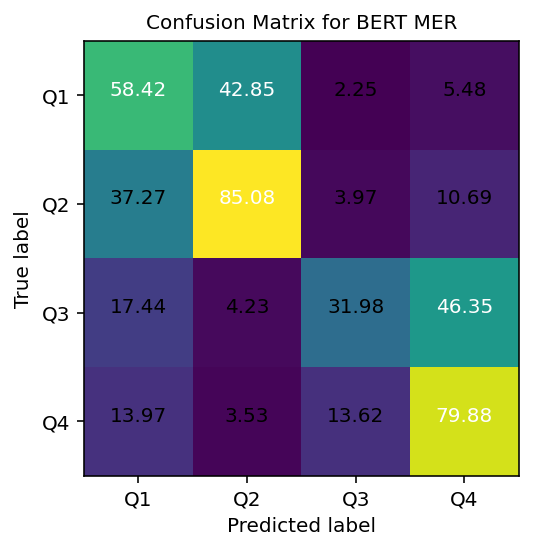

In [ ]:
import itertools

plt.figure(figsize=(8, 4))
plt.imshow(cms, interpolation='nearest')
plt.title('Confusion Matrix for BERT MER', fontsize=10)
labels = ['Q'+str(i+1) for i in range(4)]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, fontsize=10)
plt.yticks(tick_marks, labels, fontsize=10)

# print('Confusion matrix, without normalization')

thresh = cms.max() / 2.
for i, j in itertools.product(range(cms.shape[0]), range(cms.shape[1])):
    plt.text(j, i, format(cms[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cms[i, j] > thresh else "black",
                fontsize=10)

plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.savefig("bert_classification.png")

## Predict

In [54]:
model = BERTClassifier(ntokens)
model.to(device)
model.load_state_dict(torch.load('./models/bert_mer.pt'))
model.eval()

BERTClassifier(
  (embedding): Embedding(267, 512)
  (in_linear): Linear(in_features=512, out_features=252, bias=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(267, 252, padding_idx=0)
      (position_embeddings): Embedding(50, 252)
      (token_type_embeddings): Embedding(2, 252)
      (LayerNorm): LayerNorm((252,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=252, out_features=252, bias=True)
              (key): Linear(in_features=252, out_features=252, bias=True)
              (value): Linear(in_features=252, out_features=252, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(99, 42)
            )
            (output): BertSelfOutput(


In [34]:
# !pip install muspy
import muspy

In [154]:
folder = list(glob.glob('all_samples/cp vgmidi/*.mid'))
# labels = [1,2,3,4,1,1,2,3,4]
# labels = [1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4]
# labels = [1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4]
# labels = [1,1,1,1,2,3,4,1,2,3,4,1,2,3,4]
# labels = [1,2,3,4,1,2,3,4,1,2,3,4]
# labels = [1,1,1,1,2,2,2,3,3,3,4,4,4]
lables = [1,1,1,2,2,2,3,3,3,4,4,4]

In [155]:
notes, remi_enc = load_files(folder, REMI(pitch_range, additional_tokens = additional_tokens))

In [156]:
test_corpus = REMICorpus(notes, labels, remi_enc, 20)

In [157]:
batch_size = 32

test_dataloader = DataLoader(
    test_corpus,
    sampler=SequentialSampler(notes),
    batch_size=batch_size,
)

In [158]:

from sklearn.metrics import accuracy_score, confusion_matrix
model.eval()
cms = torch.zeros((4,4))
def eval(cms):
    batches = len(test_dataloader)
        
    total_loss, total_acc  = 0, 0

    with torch.no_grad():
        for bidx, (xtest, ytest)  in enumerate(test_dataloader): 
            xtest.to(device)
            ytest.to(device)

            attn_mask =  (xtest != pad_token).float().to(device)  

            y = model(xtest, attn_mask)

            y_pred = np.argmax(y.cpu().detach(), axis=-1)
            y_pred = y_pred.type(torch.float)

            acc = accuracy_score(ytest, y_pred)

            total_acc += acc


    total_acc = (total_acc / batches)

    
    print(f" Testing Accuracy: {total_acc:.7f}")

    # return cms
eval(cms)

 Testing Accuracy: 0.1250000
